# Preprocessing of EEG data

In this notebook, we will go through the basics of preprocessing EEG data using MNE. We will be using the MNE sample data, so remember to run `pip install mne[data]` from the terminal.

To preprocces the data following steps are performed
1. Load the data
2. Exclude bad channels
3. Common average reference
4. Filtering
5. Artefact rejection

After preprocessing the data is epoched for further analysis.

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load the sample data

Information about the sample data can be found [here](https://mne.tools/stable/overview/datasets_index.html). Have a quick read-through to understand the experiment. 

In [2]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = []

raw.load_data()

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 944GB/s]
Untarring contents of '/home/ucloud/mne_data/MNE-sample-data-processed.tar.gz' to '/home/ucloud/mne_data'


Attempting to create new mne-python configuration file:
/home/ucloud/.mne/mne-python.json
Opening raw data file /home/ucloud/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

### Questions
Looking at the ouput from the load_data() function, answer the following questions:

1. How many EEG channels are there?
2. Do you see any EEG channels marked as bad during recording?
3. What is the sampling frequency?
4. How many minutes of data were recorded?

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Using matplotlib as 2D backend.


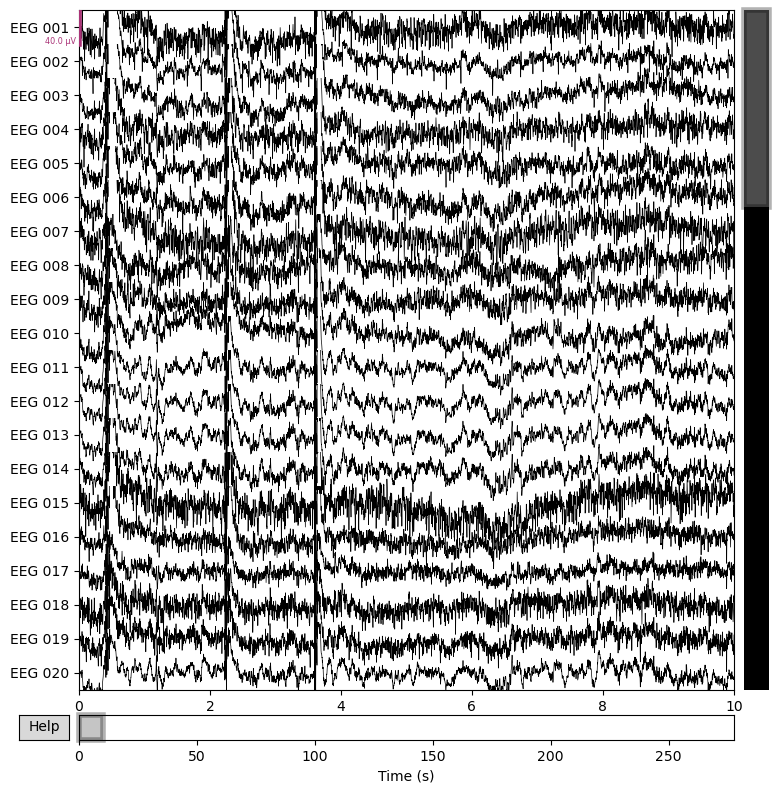

In [3]:
# selecting only EEG and stimulus data & plotting raw data
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])
raw.plot(); # the ; at the end of the line suppresses the output (if not used, the plot will be displayed twice)

Right now we are plotting using the default argument values of the plot() function. Try to play around with `Raw.plot()` method in order to:

**1. Plot all EEG channels simultaneously**

**2. Plot a full minute of the recording**

## 2. Exclude bad channels
When plotting all channels simultaneously, it is evident that one of the channels is not really picking up any signal (that is, it is flat). This is a bad channel and should be excluded from further analysis. There are other ways that channels might be bad, such as being too noisy, or picking up signals from other parts of the body. In this case, we will just exclude the channel that is flat.

**Begin by marking the channel as bad using the info attribute of the raw object. Then, plot the data again to see that the channel is now excluded.**

**After marking the channel as bad, excluded it by using the pick_types() function.**

## 3. Common average reference
The idea behind average reference is to compute the average of the signal at all EEG electrodes and subtract it from the EEG signal at every electrode for every time point. To set this “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'. This is done after excluding bad channels, so the average is computed only over the good channels.

The rationale behind this is that the average of all the potentials recorded on the whole head due to current sources inside it is zero, this would make for a quiet or electrically neutral reference. However, in practice, to achieve such an ideal reference one would require large number of electrodes that cover the whole head uniformly, which is not the case in EEG recordings where limited number of electrodes cover mostly the upper part of the head.

If you want to know more, this is a good [resource](https://pressrelease.brainproducts.com/referencing/#20).

**Set the reference for the EEG data as average reference** 

*Hint: See this [link](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html)*

**Plot the data after using the average as a reference**

## 4. Filtering
Now let's filter the data. **Apply a high-pass filter at 0.1 Hz and a low-pass filter at 40 Hz, following the typical practises of EEG preprocessing.** The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts), with frequencies higher than the frequencies of the signal we are interested in.

*Hint: The `Raw` class has a `filter()` method that can be used to filter the data*

**Plot the data to inspect the effect of the filtering**

### Question
1. Compare to the unfiltered data. What is the effect of the filtering on the data?

## 4. Artefact rejection
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just specify the treshhold and then we use it to remove artefacts while epoching further along.

There are better ways to reject artefacts, such as using the ICA algorithm. An optional exercise using ICA will be provided at the end of the notebook.

In [9]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
# this is not doing anything yet, we just specify the threshold for later!

# extra note: using a dictionary as it allows to specify different thresholds for different channels, for example if both EEG and MEG is recorded (however we only have one channel type here)
reject = {'eeg': 150e-6}

# Epoching of EEG data
Now that the data has been preprocessed, we can epoch the data. Epoching is the process of cutting the continuous data into smaller segments, called epochs. Each epoch is a time window of the data, centered around an event of interest.

In MNE toolkit, the `Epochs` class is used to represent data that has been segmented into epochs, and it provides methods for averaging, baseline correction, plotting, and so forth.

For a great overall introduction see MNE's [epoch overview](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html).

**To begin with we need to locate the events. This can be done using the find_events() function.**

**Create a dictionary of what each event ID represents.**

By using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual

**Visualise the events by using the mne.viz.plot_events() function**

**Establish a time window for the epochs.**

One suggestion is to use a time window of 200 ms before the stimulus onset to 500 ms after the stimulus onset. 
The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur. 

In [13]:
tmin, tmax = -0.2, 0.5

**Create a `picks` variable with only EEG channels**

**Create the epochs by using the mne.Epochs class**
* Use the `reject` argument to reject epochs that are above or below the threshold we set earlier
* Use the `tmin` and `tmax` arguments to set the time window for the epochs
* Use the `baseline` argument to set the baseline for the epochs (from -0.2 seconds to 0 seconds relative to the event onset) 

*Hint: See this [link](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) on the `Epochs` class*

## Downsample the data
To reduce the amount of data we have to work with as well as the amount of time it takes to run the analysis the data is downsampled. This is done after epoching, since before epoching can potentially mess with the precision of the extraction of epochs.

**Resample the data to 250 Hz**

# ERP analysis
Now that the data is epoched and resampled, we can start to analyse the data. 

**Group the epochs by modality (i.e. visual and auditory)**

*Hint: See this [link](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html#subselecting-epochs) on how to subselect epochs*

**Now use the plot_image() method of the Epochs class to plot the channel 'EEG 021' for both auditory and visual epochs**

These plots show each epoch as one row of the image map for the chosen channel, with color representing signal magnitude. The average evoked response and the sensor location are shown below the image. This gives us an idea of whether there is consistency in the signal.

### Questions
1. In your view, which is the most consistent signal of the two? Why do you think that is? (*hints: where is the EEG 021 channel located on the scalp? Try using plot_sensors and flagging show_names=True*)

2. Which channel would you choose if you were to reverse the pattern of the signal consistencies? Why? **Try it out!**

## Evoked responses
Unlike `Epochs`, which contain multiple trials that are each associated with a condition label (that is the event ID), `Evoked` objects are averages across trials for a single condition. Thus we have to create a separate `Evoked` object for each condition in our experiment.

**Create an Evoked object for each modality**

*Hint: use the average() method of the Epochs class*

**Compare the two evokeds**

*Hint: use mne.viz.plot_compare_evokeds()*

Lets have a closer look at these averaged responses, here visualised with the global field power (GFP). GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity. 

### Questions
1. Looking at the plot, where in time do is the standard deviation across all channels the highest for visual and auditory, respectively?
2. Do those timepoints match any well-known components relevant in this context? (*hint: N100 and N170*)

**Now lets use the plot_joint() method of the Evoked class to plot the evoked responses for both modalities.**

This function generates a combination of “butterfly” plots (waveforms of all electrodes overlaid) and topographic maps

### Question
1. Do those plots match your observations from the GFP-plots?

# Optional exercise: Independent Component Analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [39]:
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)

Here is some quick preprocessing code of the raw data to get you started. Just run the chunk below and read the comments. 

In [37]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = []
raw.load_data()

# pick only EEG
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])

# bad channels
raw.info['bads'] = ['EEG 053']

# common average
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')


# high-pass 
# ICA is sensitive to slow drifts, therefore we are here using a high high-pass filter! 
# Note however, that when applying the ICA, we will do it to data high-pass filtered at 0.1 Hz
# See https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA
raw_fit = raw.copy().filter(1, None)

# low-pass 
raw_fit = raw_fit.filter(None, 40)

# high and low-pass filtering for the data not used to fit the ICA
raw = raw.filter(0.1, None)

# low-pass 
raw = raw.filter(None, 40)

Opening raw data file /home/ucloud/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition 

**Set up and fit ICA with mne.preprocessing.ICA() with 800 iterations with a random seed at 7 (for reproducibility) and n_components=0.95**

n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data

**Plot the ICA components**

*Hint: ica.plot_components*

**Plot the time courses of the ICA components**

*Hint: ica.plot_sources*

### Questions
1. Which components do you suspect to be noise? (*hint: look at the topographies of the components and the time courses of the components*)

**When you have identified them, show them to Laura!**

**Exclude the eye components and apply ica to the data**

**Plot the data after filtering and using ICA to reject artefacts**

**Now like above epoch the data and downsample it. Then make the single-trial and evoked plots.**

### Question
1. Compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking?